In [16]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from ns_2d import NSTwo

fe.set_log_level(40)

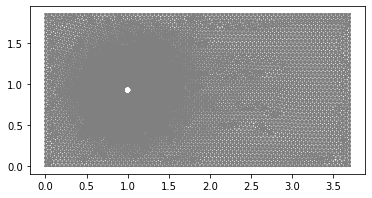

In [17]:
mesh = "../mesh/branson-mesh.xdmf"
ns = NSTwo(mesh, dict(dt=1/2000, theta=0.6, setup="branson"))
fe.plot(ns.mesh)
plt.show()

F, J = ns.setup_form(ns.du, ns.du_prev)
bcs, F = ns.setup_bcs(F)
solver = ns.setup_solver(F, ns.du, bcs, J)

In [29]:
for i in range(10):
    t += ns.dt
    
    solver.solve()
    ns.assign_prev()

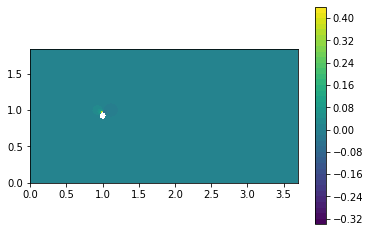

In [30]:
u, p = fe.split(ns.du)
u, v = fe.split(u)

im = fe.plot(u)
plt.colorbar(im)
plt.show()

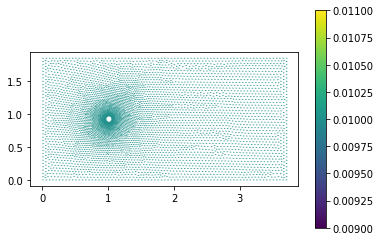

In [31]:
im = fe.plot(ns.u_in, mesh=ns.mesh)
plt.colorbar(im)
plt.show()